<a href="https://colab.research.google.com/github/gtbnhyujmj2003/Aidea-AOI/blob/master/%5BAidea%5D%5BAOI%5D%5B12%5D%20EfficientNet%20B4%20-%20%5Bopt%20%3D%20Ranger%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
!pip install -U efficientnet

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 因為圖片實在太多，所以要用壓縮檔載入

import zipfile

f = zipfile.ZipFile("./drive/My Drive/AOI/train_images.zip")
f.extractall("./datasets")

In [4]:
# 創造資料夾

import os

for class_num in range(6):
  DATASET_PATH_TRAIN = '/content/train_images/'
  DATASET_PATH_TEST = '/content/test_images/'

  # exist_ok：只有在目录不存在时创建目录，目录已存在时不会抛出异常。
  os.makedirs(DATASET_PATH_TRAIN + str(class_num), exist_ok=True)
  os.makedirs(DATASET_PATH_TEST + "test", exist_ok=True)

In [5]:
# 移動檔案

import shutil
import pandas as pd

imageAns = pd.read_csv("./drive/My Drive/AOI/train.csv")

for class_num in range(6):
  class00 = imageAns[imageAns["Label"] == class_num]
  class_list = class00["ID"]
  # print(class_list)

  for c in class_list:
    shutil.move('/content/datasets/train_images/' + str(c), 
                '/content/train_images/' + str(class_num) + "/" + str(c))

In [6]:
# Generator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
Generator = ImageDataGenerator(rescale= (1. - 127.5) / 127.5,
                               validation_split= 0.05)

In [7]:
Size = 224

In [8]:
TrainFlowGenerator = Generator.flow_from_directory(
    directory= "/content/train_images/",
    target_size= (Size, Size),
    class_mode= "sparse", 
    subset= "training")

ValidFlowGenetator = Generator.flow_from_directory(
    directory= "/content/train_images/",
    target_size= (Size, Size),
    class_mode= "sparse", 
    subset= "validation")

Found 2404 images belonging to 6 classes.
Found 124 images belonging to 6 classes.


In [9]:
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D

EfficientNet = efn.EfficientNetB4(input_shape=(Size, Size, 3),
                                  include_top=False)

x = EfficientNet.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# x = tfa.activations.mish(x)
y = Dense(6, activation="softmax")(x)

model = Model(inputs=EfficientNet.input, outputs=y)

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.optimizers import Lookahead
from tensorflow_addons.optimizers import RectifiedAdam

from tensorflow.keras.losses import SparseCategoricalCrossentropy

Radam = RectifiedAdam(lr= 1e-5)
Ranger = Lookahead(Radam, sync_period=6, slow_step_size=0.5)

model.compile(optimizer= Ranger,
              loss= SparseCategoricalCrossentropy(),
              metrics= ['accuracy'],)

In [ ]:
history = model.fit(TrainFlowGenerator, 
                    epochs=50, verbose=2,
                    validation_data= ValidFlowGenetator,
                   )

In [ ]:
# 梯度還在穩定下降，這個配方沒有問題，我預期它可以破99.50%的正確率。
# 但是跑50遍才到98.27%，學習速率的地方要改寫。

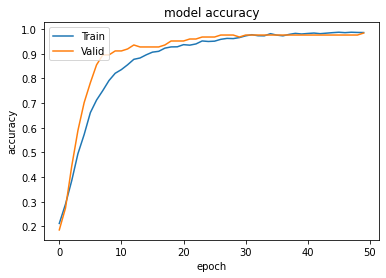

In [12]:
# accuracy

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['Train', 'Valid'], loc='upper left') 
plt.show()

In [13]:
# 載入 真．驗證資料
import zipfile

f = zipfile.ZipFile("./drive/My Drive/AOI/test_images.zip")
f.extractall("./datasets_test/")

In [14]:
TestFlowed = Generator.flow_from_directory(
    directory = "/content/datasets_test/",
    target_size= (Size, Size),
    class_mode= None,
    shuffle= False, 
    )

Found 10142 images belonging to 1 classes.


In [15]:
predict = model.predict(TestFlowed, verbose=1).argmax(axis=-1)

317/317 [==============================] - 92s 292ms/step


In [16]:
# 預言文件

import pandas as pd

result = pd.read_csv("./drive/My Drive/AOI/test.csv")

result["Label"] = list(predict)

In [17]:
# 存檔 上傳Aidea 拿成績
result.to_csv("/content/drive/My Drive/Result.csv", encoding="UTF8", index=False)

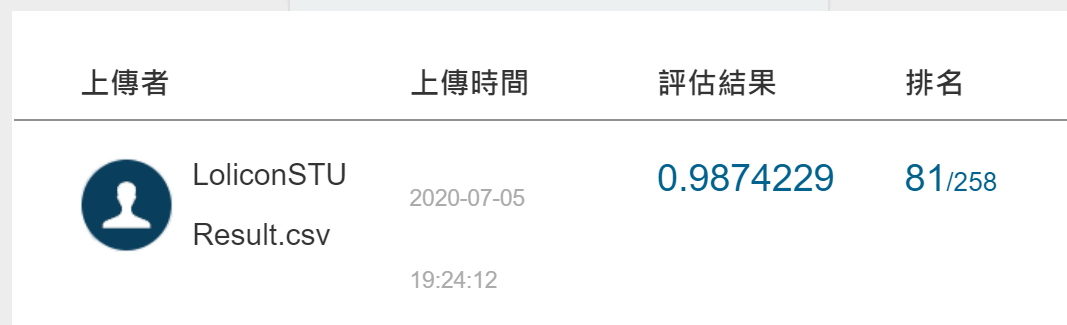

In [4]:
from tensorflow.keras.preprocessing.image import load_img

load_img('/content/drive/My Drive/GG/AA.png')